In [45]:
from models import NucleusSegmenter, CellClassifier
from data import EvaluationDataset

import torch
import numpy as np
import torchvision.transforms.functional as FT

from utils import plot_image

from matplotlib import pyplot as plt
from tqdm import tqdm

from data.utils import (
    crop_image, 
    base64_mask_to_numpy
)
from copy import deepcopy
from utils import (
    find_heatmap_peaks, 
    heatmap_to_bboxes, 
    show_heatmap_with_boxes, 
    show_heatmap_with_boxes_and_keypoints, 
    plot_image_with_keypoints
)
from torchvision.utils import make_grid
import os

In [12]:
device = "cpu"
segmenter = NucleusSegmenter().to(device)
segmenter.load_state_dict(torch.load("checkpoints/segmentation_checkpoint.pth", weights_only=False, map_location=device)["model"])
segmenter.eval()

classifier = CellClassifier()
classifier.load_state_dict(torch.load("checkpoints/classification_checkpoint.pth", weights_only=False, map_location=device)["model"])
classifier.eval();

In [30]:
@torch.no_grad()
def run_segmentation(image, method="connected_components", threshold=0.5, nms_radius=16):
    image = FT.resize(image, (224, 224))
    linspace = np.linspace(0.0, 1.0, 224)
    points = np.zeros((224, 224, 2))

    for y in range(224):
        for x in range(224):
            points[y, x, :] = [linspace[x], linspace[y]]
                
    segmentation_map = segmenter(
        torch.from_numpy(points).reshape(1, -1, 2).float(), 
        image.unsqueeze(0),
        to_prob=True
    )
    segmentation_map = segmentation_map.reshape(224, 224)
    segmentation_map[segmentation_map < threshold] = threshold
    
    if method == "connected_components":
        bboxes, keypoints = heatmap_to_bboxes(segmentation_map, threshold=threshold)
        keypoints = torch.tensor(keypoints)
        extra = {"bboxes": bboxes}

    elif method == "maxima_extraction":
        keypoints = find_heatmap_peaks(segmentation_map, min_confidence=threshold, nms_radius=12, sigma=2.0)
        extra = None
    else:
        raise
    return segmentation_map, keypoints, extra

@torch.no_grad()
def run_classification(image, keypoints):
    numpy_image = image.permute(1, 2, 0).numpy()
    H, W, _ = numpy_image.shape

    cropped_images = []
    
    for keypoint in keypoints:
        x, y = keypoint
        x, y = int(x * W), int(y * H)

        cropped_images.append(crop_image(numpy_image, (x, y), 224))

    cropped_images = torch.from_numpy(np.stack(cropped_images, 0)).permute(0, 3, 1, 2)
    predictions = classifier(cropped_images).argmax(-1)
    return predictions.tolist(), cropped_images

In [14]:
dataset = EvaluationDataset(split="test")
len(dataset)

50

In [23]:
image, class_map, mask_list = dataset[0]

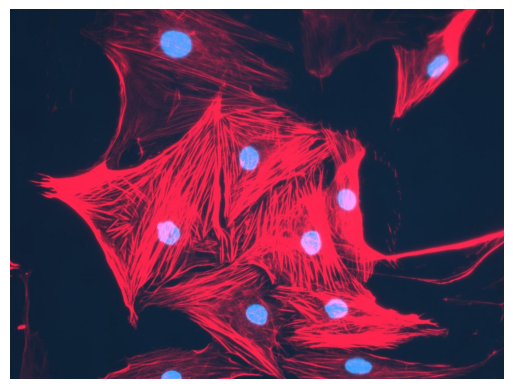

In [24]:
plot_image(image)

In [31]:
segmentation_map, keypoints, extra = run_segmentation(image, threshold=0.95, method="maxima_extraction")
class_predictions, cropped_images = run_classification(image, keypoints)

In [46]:
def show_image_grid(images, nrow=5):
    grid = make_grid(images, nrow=nrow, normalize=True, pad_value=1)
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()
def save_images(images, folder="temp"):
    os.makedirs(folder, exist_ok=True)
    for i, img in enumerate(images):
        img = img.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
        plt.imsave(os.path.join(folder, f"img_{i:02d}.png"), img)

In [47]:
save_images(cropped_images)

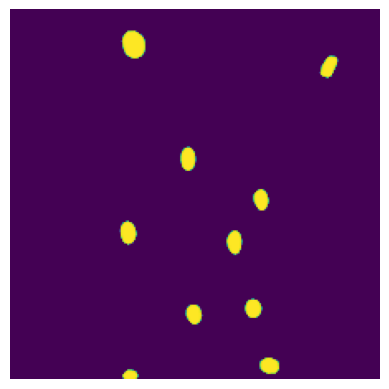

In [26]:
plot_image(segmentation_map.unsqueeze(0))

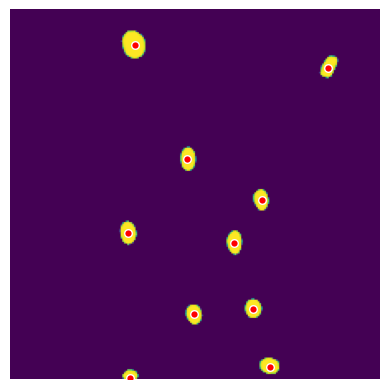

In [29]:
plot_image_with_keypoints(segmentation_map.unsqueeze(0), keypoints)

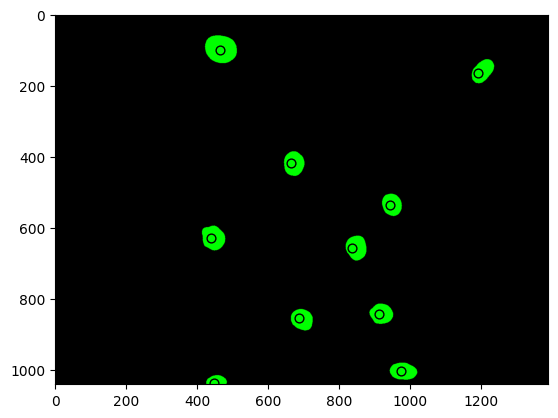

In [27]:
show_cs_map(class_map, keypoints, class_predictions)

In [21]:
def show_cs_map(cs_map, coords=None, labels=None):
    H, W = cs_map.shape
    image = np.zeros((H, W, 3))
    colors = {
        0: (0., 1., 0.),
        1: (1., 0., 0.),
    }
    image[cs_map == 0, :] = colors[0]
    image[cs_map == 1, :] = colors[1]

    plt.imshow(image, origin="upper")

    if coords is not None and labels is not None:
        for (col, row), label in zip(coords, labels):
            color = colors[label]
            plt.scatter(col * W, row * H, color=color, edgecolors="k", s=40)

    plt.show()

def scale_keypoints_to_image(image, keypoints):
    _, H, W = image.shape
    scaled_keypoints = keypoints.clone()
    scaled_keypoints[:, 0] *= W
    scaled_keypoints[:, 1] *= H
    return scaled_keypoints

In [111]:
def find_mask_match(mask_list, x, y):
    for mask in mask_list:
        x_rel, y_rel = int(x - mask["min_x"]), int(y - mask["min_y"])
        mask_width = mask["max_x"] - mask["min_x"]
        mask_height = mask["max_y"] - mask["min_y"]
        
        if not (0 <= x_rel < mask_width):
            continue
        if not (0 <= y_rel < mask_height):
            continue
    
        numpy_mask = base64_mask_to_numpy(mask["base64_mask"])[:, :, 0]
        if numpy_mask[y_rel, x_rel] != 0.:
            return mask
     
    return None

def evaluate_predictions(mask_list, keypoints, class_predictions):
    mask_list = deepcopy(mask_list)

    correct_classifications = 0
    incorrect_classifications = 0

    true_positive_detections = 0
    false_positive_detections = 0
    false_negative_detections = 0
    
    for keypoint, class_prediction in zip(keypoints, class_predictions):
        x, y = keypoint
        x, y = int(x), int(y)
        
        mask_match = find_mask_match(mask_list, x, y)
        if mask_match is not None:
            mask_list.remove(mask_match)

            true_positive_detections  += 1
            if mask_match['label'] != -1:
                if class_prediction == mask_match['label']:
                    correct_classifications   += 1
                else:
                    incorrect_classifications += 1

        else:
            false_positive_detections += 1

    false_negative_detections = len(mask_list)
    
    return {
        "correct_classifications": correct_classifications,
        "incorrect_classifications": incorrect_classifications,
        "true_positive_detections": true_positive_detections,
        "false_positive_detections": false_positive_detections,
        "false_negative_detections": false_negative_detections
    }
            
#evaluate_predictions(mask_list, scaled_keypoints, class_predictions)

In [112]:
def evaluate(threshold=0.5):
    dataset_stats = {
        "correct_classifications": 0,
        "incorrect_classifications": 0,
        "true_positive_detections": 0,
        "false_positive_detections": 0,
        "false_negative_detections": 0
    }
    
    for i in tqdm(range(len(dataset))):
        image, _, mask_list = dataset[i]
        segmentation_map, keypoints, _ = run_segmentation(image, threshold=threshold, method="maxima_extraction")
        class_predictions = run_classification(image, keypoints)
        scaled_keypoints = scale_keypoints_to_image(image, keypoints)
        
        sample_stats =  evaluate_predictions(
            mask_list, 
            scaled_keypoints, 
            class_predictions
        )
        for key in sample_stats:
            dataset_stats[key] += sample_stats[key]

    return dataset_stats
    
dataset_stats = evaluate(threshold=0.95)
dataset_stats

100%|███████████████████████████████████████████████████| 51/51 [00:17<00:00,  2.94it/s]


{'correct_classifications': 348,
 'incorrect_classifications': 14,
 'true_positive_detections': 419,
 'false_positive_detections': 5,
 'false_negative_detections': 11}

In [114]:
c_c = dataset_stats['correct_classifications']
i_c = dataset_stats['incorrect_classifications']

tp_d = dataset_stats['true_positive_detections']
fp_d = dataset_stats['false_positive_detections']
fn_d = dataset_stats['false_negative_detections']

print("Detection Metrics:")
print(f"Recall:    {(100. * (tp_d/(tp_d + fn_d))):.2f}%")
print(f"Precision: {(100. * (tp_d/(tp_d + fp_d))):.2f}%")
print("---")
print("Classification Metrics:")
print(f"Accuracy:  {100. * (c_c / (c_c + i_c)):.2f}%")

Detection Metrics:
Recall:    97.44%
Precision: 98.82%
---
Classification Metrics:
Accuracy:  96.13%
